# 这个文件用来帮助我们了解 Faster R-CNN 如何调用/训练。微调

论文地址：https://arxiv.org/pdf/1506.01497

In [2]:
import torch
import torchvision
import cv2

# load faster r-cnn model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# print the structure of the model
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


time: 0.6463656425476074
boxes:
 torch.Size([5, 4])
labels:
 torch.Size([5])
scores:
 torch.Size([5])


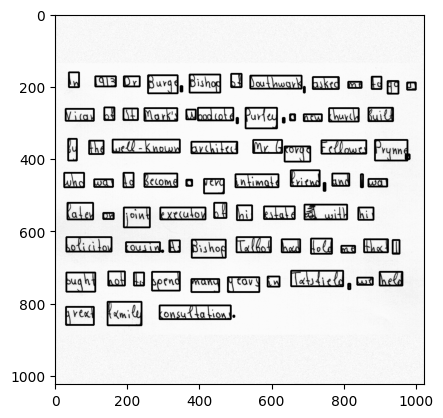

In [4]:
import torch
import torchvision.transforms as T
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import time

def load_image(img_path):
    img = Image.open(img_path)
    img = T.ToTensor()(img)
    img = img.unsqueeze(0)
    return img

def get_prediction(img, threshold):
    
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model(img)
    
    # get the prediction box
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    
    # get the index of the boxes that pass the threshold
    idx = [i for i in range(len(scores)) if scores[i] > threshold]
    
    # get the boxes that pass the threshold
    boxes = boxes[idx]
    labels = labels[idx]
    scores = scores[idx]
    
    return boxes, labels, scores

def plot_image(img, boxes):
    
    # draw boxes
    # draw = ImageDraw.Draw(img)
    # for box in boxes:
    #     draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=3)

    img = img[0]
    img -= img.min()
    img /= img.max()
    img *= 255

    # draw boxes on the image/array
    for box in boxes:
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0), 3)
    
    # plot image
    plt.imshow(img, cmap='gray')
    plt.show()

# get prediction
img_path = 'test_image.jpg'
img_path = 'test_image2.png'
threshold = 0.

from utils import *
from torchvision import transforms
dataset = ModifiedDataset(SegDataset('IAM', 'train'))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
for img, target in dataloader:
    img = img.cuda()
    break
# 加载预训练的Faster R-CNN模型
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
# 获取分类器的输入特征数
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 替换预训练的头部为一个新的，只有两个类别（背景和单词）
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load('/root/autodl-tmp/APS360_Project/Machine_Learning_Output/Faster_R_CNN/fasterrcnn_9.pth'))
model = model.cuda()

# img = load_image(img_path).cuda()
t0 = time.time()
boxes, labels, scores = get_prediction(img, -torch.inf)
t1 = time.time()
print('time:', t1-t0)
print("boxes:\n", boxes.shape)
print("labels:\n", labels.shape)
print("scores:\n", scores.shape)
plot_image(img[0].cpu().numpy(), target[0]['boxes'].cpu().numpy())
# plot_image(img[0].cpu().numpy(), boxes)

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import time

def load_image(img_path):
    img = Image.open(img_path)
    img = T.ToTensor()(img)
    img = img.unsqueeze(0)
    return img

def get_prediction(img, threshold):
    
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model(img)
    
    return boxes, labels, scores

def plot_image(img_path, boxes):
    # load image
    img = Image.open(img_path)
    
    # draw boxes
    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=3)
    
    # plot image
    plt.imshow(img)
    plt.show()

# get prediction
img_path = 'test_image.jpg'
# img_path = 'test_image2.png'
threshold = 0.
img = load_image(img_path).cuda()
t0 = time.time()
boxes, labels, scores = get_prediction(img, threshold)
t1 = time.time()
print('time:', t1-t0)
print("boxes:\n", boxes.shape)
print("labels:\n", labels.shape)
print("scores:\n", scores.shape)
# print all the attributes of the model
for i in dir(model):
    print(i)

time: 0.023154258728027344
boxes:
 torch.Size([93, 4])
labels:
 torch.Size([93])
scores:
 torch.Size([93])
T_destination
__annotations__
__call__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_apply
_backward_hooks
_backward_pre_hooks
_buffers
_call_impl
_compiled_call_impl
_forward_hooks
_forward_hooks_always_called
_forward_hooks_with_kwargs
_forward_pre_hooks
_forward_pre_hooks_with_kwargs
_get_backward_hooks
_get_backward_pre_hooks
_get_name
_has_warned
_is_full_backward_hook
_load_from_state_dict
_load_state_dict_post_hooks
_load_state_dict_pre_hooks
_maybe_warn_non_full_backward_hook
_modules
_named_members
_non_persistent_buffers_set
_parameters
_register_load_state_dict_pre_hook
_register_state_dict_hook
_replicate_for_data_

In [ ]:
for chi in model.children():
    print(chi)
    print('-' * 50)

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
--------------------------------------------------
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (d

In [ ]:
from utils import *

dataset = SegDataset('IAM', 'train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

for data, label in dataloader:
    print(data.shape, label.shape)
    break

torch.Size([32, 1, 1024, 1024]) torch.Size([32, 256, 4])
